__Testing b_star and its connection with phase transitions__

Ingnore code, read comments under the pictures. Some plot names does not correspond to an underlying graph, consult the text under the plot. 

In [1]:
import sys
sys.path.append("..")
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi, ScaleFree
from b_star import get_b_stars
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from engine_single import fun_single
from graph_toolset import coreness
import jupyternotify
import random
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>

In [2]:
def total(graph, keys):
    if 'total' in keys:
        return {'total': graph.nodes}
    else:
        return {}

In [3]:
def calc(fun_name, alphas, bs, graphs, T, init_type='01', set_builder=total, keys=['total'], pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        elif fun_name == 'single':
            cur = pool.map(fun_single, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        rem = len(graphs) - now
        print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    return res

In [4]:
def cut_alpha(data, alpha_id=0):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [5]:
def plot_means(ax, bs, data, last, keys, title, show_data=True):
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.05)

        cur = np.apply_along_axis(np.mean, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    ax.legend()
    ax.set_title(title)

In [6]:
def plot_individual(data, prob, keys, title):
    fig, ax = plt.subplots()
    
    for key in keys:
        for i in range(data[key].shape[0]):
            for j in range(data[key].shape[1]):
                for k in range(data[key].shape[2]):
                    if random.uniform(0, 1) < prob:
                        ax.plot(data[key][i][j][k])
    ax.set_title(title)
    plt.show()

In [7]:
def get_er(_):
    return ErdosRenyi(1000, 4. / 1000.)

graphs_er = Pool(32).map(get_er, [() for _ in range(500)])

In [8]:
def degs(graph, keys=[]):
    sets = dict()
    for key in keys:
        sets[key] = []
    
    for v in graph.nodes:
        d = graph.deg(v)
        if d not in keys:
            continue
        sets[d].append(v)
    return sets

In [24]:
def plot_ratios(ax, graph, scale=1, bins=100, adjusted=False):
    ratios = get_b_stars(graph, adjusted=adjusted)
    ratios = {k: v for k, v in ratios.items() if 1 < k <= 10}
    total = sum(ratios.values())
    ratios = {k: v / total * scale for k, v in ratios.items()}
    ax.hist(list(ratios.keys()), weights=list(ratios.values()), bins=bins)

In [22]:
def plot_ratios_and_means(res, graph, scale=2, bins=100, adjusted=False):
    fig, ax = plt.subplots() 
    plot_means(ax, partition(0, 10, 256), cut_alpha(res), 200, ['total'], '-', show_data=False)
    plot_ratios(ax, graph, scale=scale, bins=bins, adjusted=adjusted)
    plt.show()

In [24]:
res = calc('fun', [.1], partition(0, 10, 256), graphs_er[0:1]*10, 200, set_builder=total, keys=['total'])

#1 passed in 45.98750400543213,  projected end in 6.898131394386292 minutes
#2 passed in 46.2032630443573,  projected end in 6.146190404891968 minutes
#3 passed in 47.017863512039185,  projected end in 5.413801933659448 minutes
#4 passed in 46.452932834625244,  projected end in 4.641650468111038 minutes
#5 passed in 46.508835554122925,  projected end in 3.869596735636393 minutes
#6 passed in 45.58975410461426,  projected end in 3.0862939569685195 minutes
#7 passed in 45.54998207092285,  projected end in 2.309409495762416 minutes
#8 passed in 46.09189224243164,  projected end in 1.5392096092303593 minutes
#9 passed in 46.7619833946228,  projected end in 0.7706912159919739 minutes
#10 passed in 46.031532764434814,  projected end in 0.0 minutes
time elapsed = 462.20946741104126


__One strategy per edge model__  
Average cooperation rate for a __single__ graph is plotted over 20 runs.   
Under the cooperation rate, histogram of frequencies b* is plotted. b* are filtered to lie in (1, 10] semi-interval.

<IPython.core.display.Javascript object>


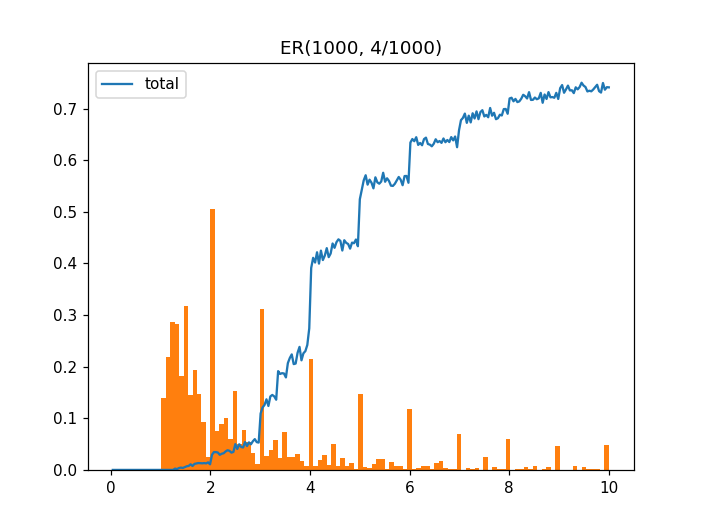

In [35]:
fig, ax = plt.subplots() 
plot_means(ax, partition(0, 10, 256), cut_alpha(res), 20, ['total'], 'ER(1000, 4/1000)', show_data=False)
plot_ratios(ax, graphs_er[0], scale=5)
plt.show()

On the plot above, we can see that in Erods-Renyi model, phase transitions are indeed correlate with frequency of b*.

In [26]:
graph23 = GraphByDegrees({2: 500, 3: 500})
res23 = calc('fun', [.1], partition(0, 10, 256), [graph23]*10, 1000, set_builder=total, keys=['total'])

#1 passed in 199.88788747787476,  projected end in 29.98318930864334 minutes
#2 passed in 200.32898426055908,  projected end in 26.681303628285725 minutes
#3 passed in 202.66911697387695,  projected end in 23.445755966504414 minutes
#4 passed in 199.5582730770111,  projected end in 20.06125938296318 minutes
#5 passed in 199.1129069328308,  projected end in 16.692740682760874 minutes
#6 passed in 197.8845853805542,  projected end in 13.327223398950364 minutes
#7 passed in 198.65969109535217,  projected end in 9.986510629313333 minutes
#8 passed in 199.5808334350586,  projected end in 6.657064193487168 minutes
#9 passed in 199.55962586402893,  projected end in 3.328252473583928 minutes
#10 passed in 198.30047082901,  projected end in 0.0 minutes
time elapsed = 1995.573885679245


<IPython.core.display.Javascript object>


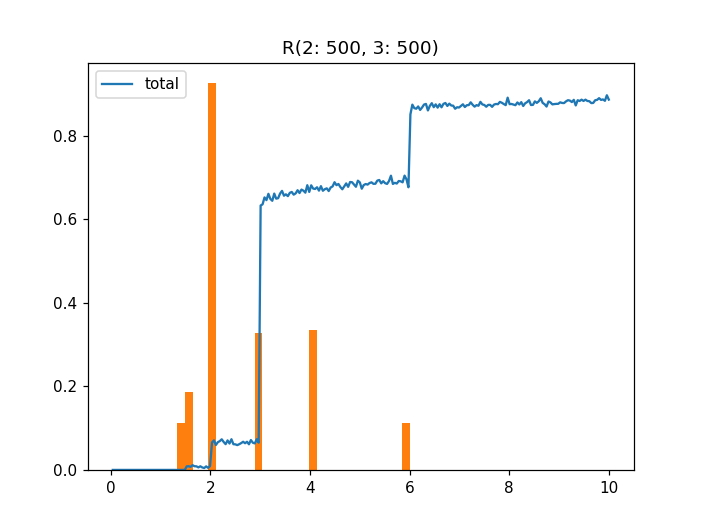

In [31]:
fig, ax = plt.subplots() 
plot_means(ax, partition(0, 10, 256), cut_alpha(res23), 200, ['total'], 'R(2: 500, 3: 500)', show_data=False)
plot_ratios(ax, graph23, scale=2, bins=30, adjusted=True)
plt.show()

As we can see, if there is a phase transition, there are always concentration of b*. Inverse is not true.

In [9]:
graph3 = GraphByDegrees({3: 1000})
graph35 = GraphByDegrees({3: 500, 5: 500})
res3 = calc('fun', [.1], partition(0, 10, 256), [graph3]*10, 1000, set_builder=total, keys=['total'])
res35 = calc('fun', [.1], partition(0, 10, 256), [graph35]*10, 1000, set_builder=total, keys=['total'])

#1 passed in 204.9448745250702,  projected end in 30.741736364364623 minutes
#2 passed in 204.28397488594055,  projected end in 27.28214014371236 minutes
#3 passed in 204.88519740104675,  projected end in 23.882390746805406 minutes
#4 passed in 203.16182374954224,  projected end in 20.43204991221428 minutes
#5 passed in 204.37808346748352,  projected end in 17.027688030401865 minutes
#6 passed in 205.23781323432922,  projected end in 13.632224350505405 minutes
#7 passed in 204.32133507728577,  projected end in 10.22301893574851 minutes
#8 passed in 204.42937564849854,  projected end in 6.815222370624542 minutes
#9 passed in 209.87627124786377,  projected end in 3.417649946389375 minutes
#10 passed in 215.25400161743164,  projected end in 0.0 minutes
time elapsed = 2060.7977986335754
#1 passed in 246.85288882255554,  projected end in 37.027938830852506 minutes
#2 passed in 244.60247254371643,  projected end in 32.76391574541728 minutes
#3 passed in 242.40609550476074,  projected end in 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call la

  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", 

  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multipro

  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
Process ForkPoolWorker-4:
Process ForkPoolWorker-31:
Process ForkPoolWorker-2:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-49:
Process ForkPoolWorker-22:
Process ForkPoolWorker-47:
Process ForkPoolWorker-36:
Process ForkPoolWorker-24:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/p

  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/pytho

<IPython.core.display.Javascript object>


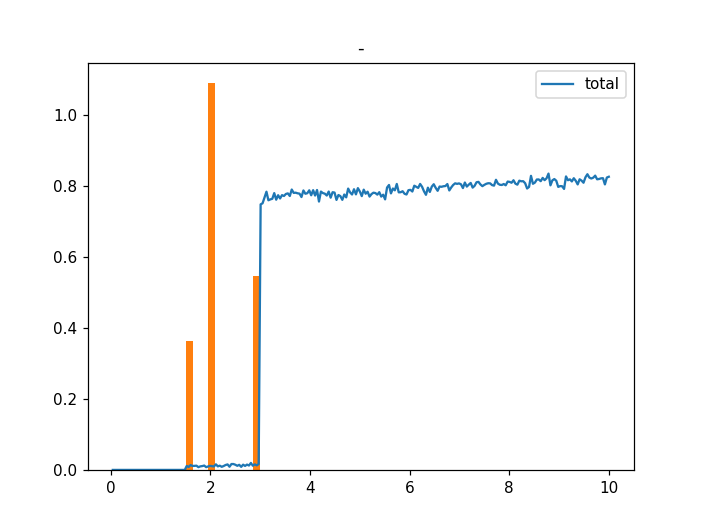

In [27]:
plot_ratios_and_means(res3, graph3, bins=10)

Regular graph with degree 3.

<IPython.core.display.Javascript object>


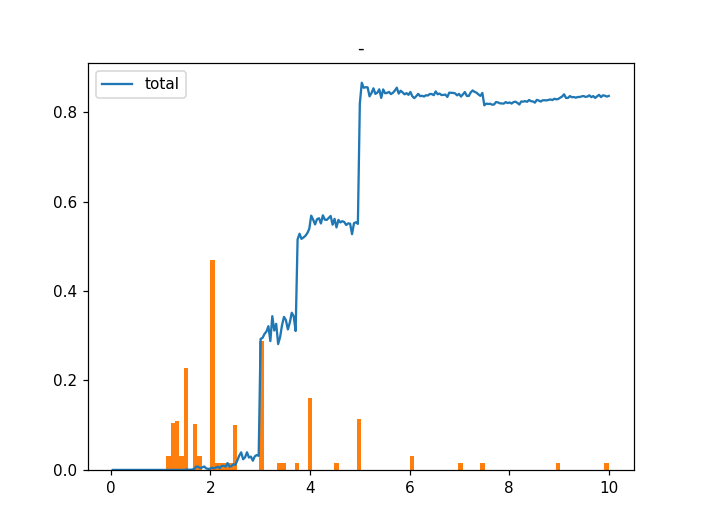

In [29]:
plot_ratios_and_means(res35, graph35, bins=100)

__Single strategy pre node__

In [30]:
res3s = calc('single', [.1], partition(0, 10, 256), [graph3]*10, 1000, set_builder=total, keys=['total'])

#1 passed in 170.93089652061462,  projected end in 25.63963919878006 minutes
#2 passed in 170.15264916419983,  projected end in 22.739065217971802 minutes
#3 passed in 171.28316521644592,  projected end in 19.925512772136265 minutes
#4 passed in 171.53574109077454,  projected end in 17.097718793153764 minutes
#5 passed in 172.01334071159363,  projected end in 14.265390320618947 minutes
#6 passed in 172.5171766281128,  projected end in 11.427132884661356 minutes
#7 passed in 173.29002332687378,  projected end in 8.58381075348173 minutes
#8 passed in 172.56213212013245,  projected end in 5.726236958305041 minutes
#9 passed in 173.50876641273499,  projected end in 2.8663090569001657 minutes
#10 passed in 172.59739446640015,  projected end in 0.0 minutes
time elapsed = 1720.4140391349792


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line

  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/conne

  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/queues.py", 

In [31]:
res35s = calc('single', [.1], partition(0, 10, 256), [graph35]*10, 1000, set_builder=total, keys=['total'])

#1 passed in 195.1049449443817,  projected end in 29.265746426582336 minutes
#2 passed in 194.4465696811676,  projected end in 25.970333496729534 minutes
#3 passed in 193.3026146888733,  projected end in 22.6667319893837 minutes
#4 passed in 194.153094291687,  projected end in 19.42534837126732 minutes
#5 passed in 194.11143684387207,  projected end in 16.1854474623998 minutes
#6 passed in 195.82324194908142,  projected end in 12.96612535847558 minutes
#7 passed in 197.28689217567444,  projected end in 9.744567225660596 minutes
#8 passed in 198.30439352989197,  projected end in 6.510604434212049 minutes
#9 passed in 198.31874251365662,  projected end in 3.2608614961306253 minutes
#10 passed in 195.70450830459595,  projected end in 0.0 minutes
time elapsed = 1956.5806441307068


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multipro

  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInte

  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/li

<IPython.core.display.Javascript object>


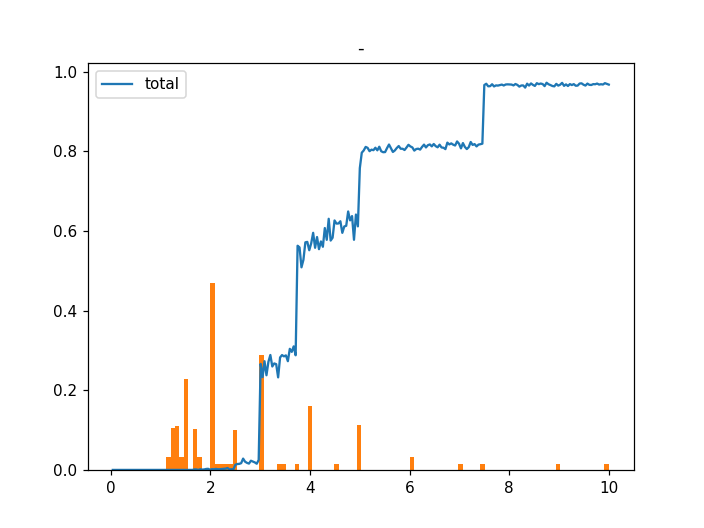

In [32]:
plot_ratios_and_means(res35s, graph35, bins=100)

Graph R(3: 500, 5: 500), single strategy per node.

<IPython.core.display.Javascript object>


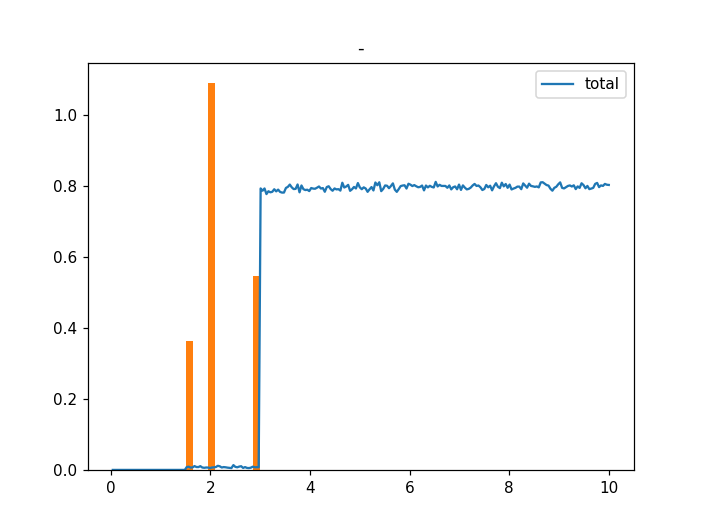

In [34]:
plot_ratios_and_means(res3s, graph3, bins=10)

3-regular graph, single strategy per node.

In [35]:
graphER = ErdosRenyi(1000, 4 / 1000)
resERs = calc('single', [.1], partition(0, 10, 256), [graphER]*10, 1000, set_builder=total, keys=['total'])

#1 passed in 193.15920090675354,  projected end in 28.973886322975158 minutes
#2 passed in 200.00623035430908,  projected end in 26.21116854349772 minutes
#3 passed in 197.78769254684448,  projected end in 22.981648622618778 minutes
#4 passed in 198.75196766853333,  projected end in 19.742759555578232 minutes
#5 passed in 198.47014045715332,  projected end in 16.469696549574532 minutes
#6 passed in 199.29231429100037,  projected end in 13.1941764248742 minutes
#7 passed in 199.24263739585876,  projected end in 9.905141397884913 minutes
#8 passed in 197.47262954711914,  projected end in 6.600808430711428 minutes
#9 passed in 197.25486063957214,  projected end in 3.298981908074132 minutes
#10 passed in 197.4370641708374,  projected end in 0.0 minutes
time elapsed = 1978.8992140293121


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


  File "/usr/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
Traceback (most recent call last):
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self

  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7

<IPython.core.display.Javascript object>


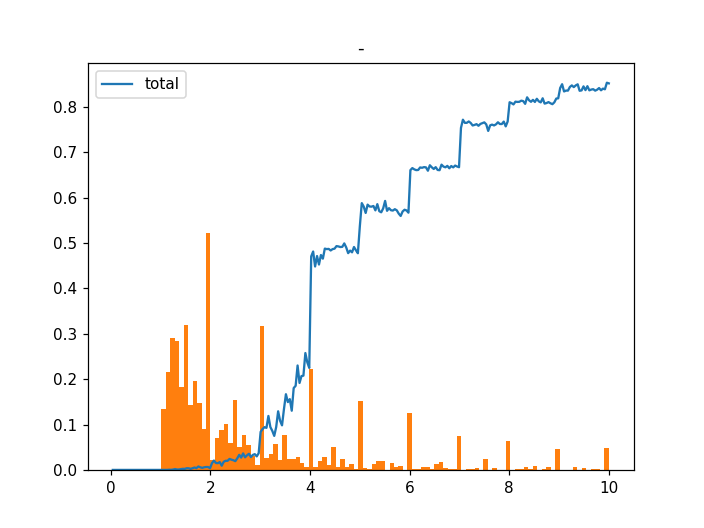

In [39]:
plot_ratios_and_means(resERs, graphER, bins=100, scale=5)

Erdos-Renyi graph, single strategy per node.

In [14]:
graphSF = ScaleFree(100, 3)

In [19]:
resSFs = calc('single', [.1], partition(0, 10, 256), [graphSF]*200, 1000, set_builder=total, keys=['total'])

#1 passed in 22.974083185195923,  projected end in 76.19749846458436 minutes
#2 passed in 22.849560260772705,  projected end in 75.61459980010986 minutes
#3 passed in 22.746102809906006,  projected end in 75.05180494387945 minutes
#4 passed in 22.6719970703125,  projected end in 74.51925599972407 minutes
#5 passed in 22.747485160827637,  projected end in 74.09771772623063 minutes
#6 passed in 22.758423805236816,  projected end in 73.69632822672526 minutes
#7 passed in 22.709402322769165,  projected end in 73.27862806433723 minutes
#8 passed in 22.701292037963867,  projected end in 72.86743764877319 minutes
#9 passed in 22.729894161224365,  projected end in 72.47369977147491 minutes
#10 passed in 22.775514602661133,  projected end in 72.09734688599904 minutes
#11 passed in 22.82348322868347,  projected end in 71.73412620696155 minutes
#12 passed in 22.941664695739746,  projected end in 71.39899636242126 minutes
#13 passed in 22.735156774520874,  projected end in 71.00704716596847 minute

#107 passed in 22.770790100097656,  projected end in 35.27257376207369 minutes
#108 passed in 22.918439149856567,  projected end in 34.8956088832867 minutes
#109 passed in 22.956377744674683,  projected end in 34.51908464318751 minutes
#110 passed in 22.749066591262817,  projected end in 34.13961903073571 minutes
#111 passed in 22.689288854599,  projected end in 33.75936113635341 minutes
#112 passed in 22.742695331573486,  projected end in 33.3798402706782 minutes
#113 passed in 22.787153244018555,  projected end in 33.000895697247664 minutes
#114 passed in 22.79153609275818,  projected end in 32.621991564865 minutes
#115 passed in 22.758225202560425,  projected end in 32.24266813596089 minutes
#116 passed in 22.75591015815735,  projected end in 31.863312188921302 minutes
#117 passed in 22.75021481513977,  projected end in 31.48390937608871 minutes
#118 passed in 22.714161157608032,  projected end in 31.104070971375805 minutes
#119 passed in 22.75366973876953,  projected end in 30.7247

<IPython.core.display.Javascript object>


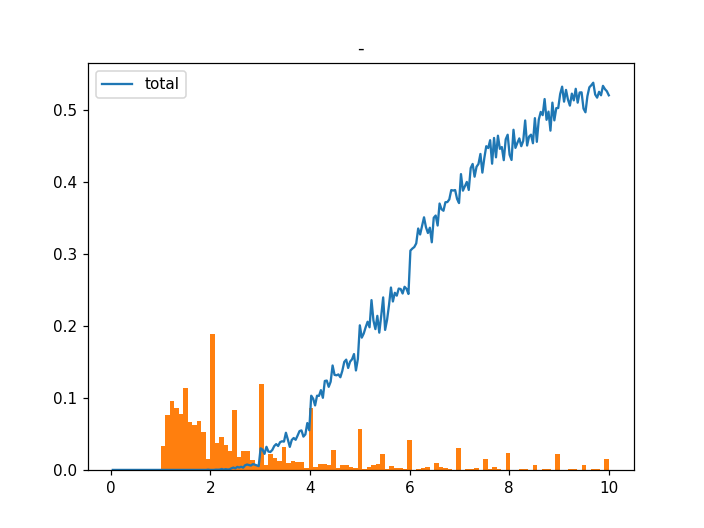

In [25]:
plot_ratios_and_means(resSFs, graphSF, adjusted=True)

Actually, here histogram is 'adjusted', meaning that we include initial distribution on incoming/outcoming cooperation rate. 

Scale-Free graph. Scale-Free graph require a lot of iterations to converge and exhibit large variation. This may be due to large variation in scale free graph degrees.